# CMSC320 Project 1 - Jerry Catron
***


## Part 1: Data Scraping & Cleaning

These are some of the python modules we will be using in this analysis. They are separated by use-case.

In [1]:
# Data Science
import pandas as pd
import numpy as np

# Web-Scraping
import requests
from bs4 import BeautifulSoup

# Misc
import re
import datetime

### Step 1: Scrape Space Weather Live

We will be scraping our first dataset from spaceweatherlive.com using python's 'requests' library for HTTP requests. First we will specify a User Agent in the header to imitate a normal browser. This helps us circum-navigate the website bot-protection. Then we make a GET request to the URL where the top 50 solar flares table is located. Once we have our HTML data from the webpage, we use the BeautifulSoup module to parse it.

In [2]:
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.150 Safari/537.36'}

spaceweather_page = requests.get('https://www.spaceweatherlive.com/en/solar-activity/top-50-solar-flares.html', headers=headers)

spaceweather_html_root = BeautifulSoup(spaceweather_page.text, 'lxml')



Now that we've scraped our data, we need to clean it. First, we use CSS selectors and BeautifulSoup's select() method to extract the table from the raw HTML. Then we make use of pandas' read_html() function to convert the HTML table into a pandas DataFrame. 

Once we've created the DataFrame, we assign meaningful column names to correspond with Space Weather Live's table online. Also note that there is a 'MovieView archive' column of links from the HTML table. We won't neep that in our analysis, so we drop the column.

Pandas head() function displays the first 5 rows of a DataFrame. We can use this to check that our columns are formatted as expected so far.

In [3]:
spaceweather_html_table = spaceweather_html_root.select('table.table.table-striped.table-responsive-md')

[swl_df] = pd.read_html(str(spaceweather_html_table), flavor = 'lxml')

columns = ['rank', 'x_class', 'date', 'region', 'start_time', 'max_time', 'end_time', 'movie']
swl_df.columns = columns

swl_df_nomovie = swl_df.drop(['movie'], axis=1)

display(swl_df_nomovie.head())

,rank,x_class,date,region,start_time,max_time,end_time
0,1,X28+,2003/11/04,486,19:29,19:53,20:06
1,2,X20+,2001/04/02,9393,21:32,21:51,22:03
2,3,X17.2+,2003/10/28,486,09:51,11:10,11:24
3,4,X17+,2005/09/07,808,17:17,17:40,18:03
4,5,X14.4,2001/04/15,9415,13:19,13:50,13:55


### Step 2: Tidying Top 50 Solar Flares data

Now that we've cleaned away our unwanted data, we need to tidy/transform some of the remaining data to make it more useful. Python's datetime objects make working with time easy and comparable. So in order to convert our separate date and time strings into a singular datetime object, we will first concatenate the date and time strings in a new column, then use a conversion method. In this part I used datetime.datetime.strptime(), although pd.to_datetime() could also be used.

In [4]:
# makes a new copy to mutate
swl_df_nomovie = swl_df_nomovie.copy()

# Concatenating date column to time columns
swl_df_nomovie['start_datetime'] = swl_df_nomovie['date'] + ' ' + swl_df_nomovie['start_time']
swl_df_nomovie['max_datetime'] = swl_df_nomovie['date'] + ' ' + swl_df_nomovie['max_time']
swl_df_nomovie['end_datetime'] = swl_df_nomovie['date'] + ' ' + swl_df_nomovie['end_time']

# Drops the old date and time columns
swl_df_datetime1 = swl_df_nomovie.drop(['date', 'start_time', 'max_time', 'end_time'], axis=1)

# makes a new copy to mutate
swl_df_datetime2 = swl_df_datetime1.copy()

# Converting strings to datetime objects
swl_df_datetime2['start_datetime'] = swl_df_datetime1['start_datetime'].map(lambda x: datetime.datetime.strptime(x, '%Y/%m/%d %H:%M'))
swl_df_datetime2['max_datetime'] = swl_df_datetime1['max_datetime'].map(lambda x: datetime.datetime.strptime(x, '%Y/%m/%d %H:%M'))
swl_df_datetime2['end_datetime'] = swl_df_datetime1['end_datetime'].map(lambda x: datetime.datetime.strptime(x, '%Y/%m/%d %H:%M'))

swl_df_datetime2.head()


,rank,x_class,region,start_datetime,max_datetime,end_datetime
0,1,X28+,486,2003-11-04 19:29:00,2003-11-04 19:53:00,2003-11-04 20:06:00
1,2,X20+,9393,2001-04-02 21:32:00,2001-04-02 21:51:00,2001-04-02 22:03:00
2,3,X17.2+,486,2003-10-28 09:51:00,2003-10-28 11:10:00,2003-10-28 11:24:00
3,4,X17+,808,2005-09-07 17:17:00,2005-09-07 17:40:00,2005-09-07 18:03:00
4,5,X14.4,9415,2001-04-15 13:19:00,2001-04-15 13:50:00,2001-04-15 13:55:00


And just like that we have a beautiful DataFrame of Space Weather Live's top 50 solar flares that we can perform analysis on.

## Step 3: Scraping NASA data

For our next dataset we will be scraping from a webpage maintained by NASA, located at https://cdaw.gsfc.nasa.gov/CME_list/radio/waves_type2.html. We will use some of the same methods as above, but this data does not come prepackaged in a HTML table for us. Thus we will have to use some tricky string parsing to get the job done.

For the NASA data we don't need a custom header, so we can just go right ahead and read the HTML from the URL using a GET request.
Then we will use BeautifulSoup again to parse the raw HTML.

The output of the BeautifulSoup is redacted due to PDF exporting issues with the prettify() function.

In [5]:
nasa_page = requests.get('https://cdaw.gsfc.nasa.gov/CME_list/radio/waves_type2.html')

nasa_html_root = BeautifulSoup(nasa_page.text, 'lxml')

# Prints outs the parsed HTML of the page starting from the root of the DOM
# nasa_html_root.prettify()



Now that we have the HTML, we need to clean it. All of the relevant information is stored in an HTML tag called 'pre', so use BeautifulSoup to extracct that tag and its inner text. We then split the text on the new line character '\n'. This gives us a list of strings where each element corresponds to a row of the table.

In [6]:
nasa_html_pre = nasa_html_root.find('pre')

nasa_pre_string_rows = nasa_html_pre.get_text().split("\n")


Some of the rows contain extraneous data/comments from the page's maintainer, as well as tons of whitespace; so we will ignore the rows that don't start with a 1 or 2 (start_date), and from there we split on every whitespace.

This leaves us with a list of lists representation of our table of rows, which is progress. However many of our lists (rows) contain empty strings which will mess up the format of our DataFrame, so we need to remove those using remove(). Similar to the Space Weather Live dataset, each row of the table contained a link to visualizations of the solar flare. All that's left is the text 'PHTX', which we can remove.

Once all that is done our list of string lists is a valid form to pass in to pandas Dataframe constructor.

In [7]:
nasa_filtered_rows = [x.split(' ') for x in nasa_pre_string_rows if re.match(r'^[1-2]', x)]

for row in nasa_filtered_rows:
    row.remove('PHTX')
    while '' in row:
        row.remove('')

nasa_df = pd.DataFrame(nasa_filtered_rows)

## Step 4: Tidying NASA data

So now that we have the NASA data in a DataFrame, let's take a quick look at the first 5 rows using head() to see if there are any glaring issues.

In [8]:
nasa_df.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,1997/04/01,14:00,04/01,14:15,8000,4000,S25E16,8026,M1.3,04/01,...,312,None,None,None,None,None,None,None,None,None
1,1997/04/07,14:30,04/07,17:30,11000,1000,S28E19,8027,C6.8,04/07,...,878,None,None,None,None,None,None,None,None,None
2,1997/05/12,05:15,05/14,16:00,12000,80,N21W08,8038,C1.3,05/12,...,464,None,None,None,None,None,None,None,None,None
3,1997/05/21,20:20,05/21,22:00,5000,500,N05W12,8040,M1.3,05/21,...,296,None,None,None,None,None,None,None,None,None
4,1997/09/23,21:53,09/23,22:16,6000,2000,S29E25,8088,C1.4,09/23,...,712,None,None,None,None,None,None,None,None,None


As you can see columns 14-22 have nothing in them! Also, the columns are labelled 0, 1, 2, ...
We can't have this, so let's remedy it immediately using pandas DataFrame.iloc slicer and DataFrame.columns attribute

In [9]:
# removing un-needed columns 12-23
nasa_df = nasa_df.iloc[:, 0:14]

nasa_df.columns = ['start_date', 'start_time', 'end_date','end_time', 'start_frequency', 'end_frequency', 'flare_location', 'flare_region', 'flare_class', 'cme_date', 'cme_time', 'cme_angle', 'cme_width', 'cme_speed']



Now that we've trimmed and labelled the columns, let's deal with the missing data. Upon inital inspection of the webpage I noticed some values interpsresed in the table that the NASA researchers used when data was not properly recorded. For convenience sake we are going to set all such values to NaN (not a number).

I've also included a code snippet that allows you to view all rows of the dataset to check for any missing values left after the recoding, but to enhance the brevity of this document the output will not be included.

In [10]:
nasa_df = nasa_df.applymap(lambda x: np.nan if x in ['EP', 'FILA', 'DIM', 'DSF', 'altr', '----', '-----', 'BACK', 'Back', '--/--', '--:--'] else x)

# uncomment to output all rows to check NaN recoding
# pd.options.display.max_rows = 1000
# display(nasa_df)
# pd.options.display.max_rows = 0

Great, so we've dealt with the missing data, but our tidying doesn't end there. Upon further inspection you'll notice some of the columns have values that don't jive with the rest of the column. I'm talking about the 'Halo' observations in 'cme_angle' and the greater tahn symbols '>' in 'cme_width'. 

To properly represent our observation/variable structure, we will create new columns of boolean values. One will indicate if a solar flare is a Halo, and the other will indicate whether the cme width reported is a lower bound approximation, not an exact value.

Once we've created those columns, we will populate the value for each row using some tricky pandas indexing. 

In [11]:
# inserting new column to indicate True/False for halo CME
nasa_df.insert(loc=len(nasa_df.columns), column='is_halo', value=False)
nasa_df.insert(loc=len(nasa_df.columns), column='width_lower_bound', value=False)

# Creating 'is_halo' column for Halo CMEs observation to be set to true
# Then setting cme_angle Halo observations to NaN to tidy the variable to only integers
nasa_df.loc[:, 'is_halo'] = nasa_df['cme_angle'].str.contains('Halo', na=False)
nasa_df.loc[nasa_df['cme_angle'] == 'Halo', 'cme_angle'] = np.nan

# Creating 'width_lower_bound' column for uncertain width observations to be set to true
# Then slicing cme_width  observations to remove '>' to tidy the variable to only integers
nasa_df.loc[:, 'width_lower_bound'] = nasa_df['cme_width'].str.contains('>', na=False)
nasa_df.loc[nasa_df['cme_width'].str.contains('>', na=False), 'cme_width'] = nasa_df['cme_width'].str.slice(start=1)


Great! Now let's take a look at the results of all our hard work to ensure we were successful.

In [12]:
nasa_df.head()

,start_date,start_time,end_date,end_time,start_frequency,end_frequency,flare_location,flare_region,flare_class,cme_date,cme_time,cme_angle,cme_width,cme_speed,is_halo,width_lower_bound
0,1997/04/01,14:00,04/01,14:15,8000,4000,S25E16,8026,M1.3,04/01,15:18,74,79,312,False,False
1,1997/04/07,14:30,04/07,17:30,11000,1000,S28E19,8027,C6.8,04/07,14:27,NaN,360,878,True,False
2,1997/05/12,05:15,05/14,16:00,12000,80,N21W08,8038,C1.3,05/12,05:30,NaN,360,464,True,False
3,1997/05/21,20:20,05/21,22:00,5000,500,N05W12,8040,M1.3,05/21,21:00,263,165,296,False,False
4,1997/09/23,21:53,09/23,22:16,6000,2000,S29E25,8088,C1.4,09/23,22:02,133,155,712,False,False


Just like the Space Weather Live data, we want to convert out separate date and time strings into singular datetime objects for each stage of the flare (start, end, cme). However this time the NASA researchers made it tough on us. They decided to use ISO 8601 format, which allows the time of day to range from 00:00-24:00. This is an issue, because python's datetime objects can't account for 24:00. So we need to do some handywork.

I decomposed the date and times from each row into integers that could be easily compared and manipulated. When times with 24:00 are found, we change the time to 00:00, and advance to the next day. However there are some edge cases to deal with when advancing the day, such as starting a new month and year. 

Once I'm sure the strings are properly formatted, I can construct datetime objects using the decomposed variables for year, month, day, hour, and minute. 

In [13]:
from calendar import monthrange

# create temporary by extracting date and time columns
dt_temp = nasa_df.loc[:, ['start_date', 'start_time', 'end_date', 'end_time', 'cme_date', 'cme_time']].copy()

# custom function to convert each row to datetime objs
def create_datetimes(row):

    # regex patterns to extract date and time values for modification
    pattern_time = '(\d{2}):(\d{2})'                # hh:mm
    pattern_date2 = '(\d{2})/(\d{2})'               # MM/DD
    pattern_date3 = '(\d{4})/(\d{2})/(\d{2})'       # YYYY/MM/DD

    # decomposing the regex matches into int variables
    (start_year, start_month, start_day) = map(int, re.search(pattern_date3, row['start_date']).groups())
    (start_hour, start_minute) = map(int, re.search(pattern_time, row['start_time']).groups())
    (end_month, end_day) = map(int, re.search(pattern_date2, row['end_date']).groups())
    (end_hour, end_minute) = map(int, re.search(pattern_time, row['end_time']).groups())
    # some of the cme values are nan so we handle this by making the values NaT
    try:
        (cme_month, cme_day) = map(int, re.search(pattern_date2, row['cme_date']).groups())
    except:
        cme_month = cme_day = pd.NaT
    try:
        (cme_hour, cme_minute) = map(int, re.search(pattern_time, row['cme_time']).groups())
    except:
        cme_hour = cme_minute = pd.NaT 

    # advances the date by one day if time is 24:00
    if start_hour == 24:
        start_hour = 00
        start_day += 1
        # returns the number of days in given month
        (weekday, num_days) = monthrange(start_year, start_month)
        if start_day > num_days:
            start_month += 1
            start_day = 1
            if start_month > 12:
                start_month = 1
                start_year += 1
    end_year = start_year
    if end_hour == 24:
        end_hour = 00
        end_day += 1
        (weekday, num_days) = monthrange(end_year, end_month)
        if end_day > num_days:
            end_month += 1
            end_day = 1
            if end_month > 12:
                end_month = 1
                end_year += 1
    if end_month < start_month:
        end_year += 1
    cme_year = start_year
    if cme_day and cme_hour and cme_minute and cme_month and cme_year:
        if cme_hour == 24:
            cme_hour = 00
            cme_day += 1
            (weekday, num_days) = monthrange(cme_year, cme_month)
            if cme_day > num_days:
                cme_month += 1
                cme_day = 1
                if cme_month > 12:
                    cme_month = 1
        if cme_month < start_month:
            cme_year += 1

    # if one of the values is None, the datetime is set to Not a Time
    try:
        row['start_datetime'] = datetime.datetime(start_year, start_month, start_day, hour=start_hour, minute=start_minute)
    except:
        row['start_datetime'] = pd.NaT
    try:
        row['cme_datetime'] = datetime.datetime(cme_year, cme_month, cme_day, hour=cme_hour, minute=cme_minute)
    except:
        row['cme_datetime'] = pd.NaT
    try:
        row['end_datetime'] = datetime.datetime(end_year, end_month, end_day, hour=end_hour, minute=end_minute)
    except:
        row['end_datetime'] = pd.NaT    
    
    return row
    
mod_dt_temp = dt_temp.apply(create_datetimes, axis=1)

mod_dt_temp.head(100)

,start_date,start_time,end_date,end_time,cme_date,cme_time,start_datetime,cme_datetime,end_datetime
0,1997/04/01,14:00,04/01,14:15,04/01,15:18,1997-04-01 14:00:00,1997-04-01 15:18:00,1997-04-01 14:15:00
1,1997/04/07,14:30,04/07,17:30,04/07,14:27,1997-04-07 14:30:00,1997-04-07 14:27:00,1997-04-07 17:30:00
2,1997/05/12,05:15,05/14,16:00,05/12,05:30,1997-05-12 05:15:00,1997-05-12 05:30:00,1997-05-14 16:00:00
3,1997/05/21,20:20,05/21,22:00,05/21,21:00,1997-05-21 20:20:00,1997-05-21 21:00:00,1997-05-21 22:00:00
4,1997/09/23,21:53,09/23,22:16,09/23,22:02,1997-09-23 21:53:00,1997-09-23 22:02:00,1997-09-23 22:16:00
...,...,...,...,...,...,...,...,...,...
95,2000/11/12,14:25,11/12,14:40,11/12,14:50,2000-11-12 14:25:00,2000-11-12 14:50:00,2000-11-12 14:40:00
96,2000/11/23,08:16,11/23,08:35,11/23,06:06,2000-11-23 08:16:00,2000-11-23 06:06:00,2000-11-23 08:35:00
97,2000/11/23,21:00,11/23,21:06,11/23,21:30,2000-11-23 21:00:00,2000-11-23 21:30:00,2000-11-23 21:06:00
98,2000/11/24,05:10,11/24,15:00,11/24,05:30,2000-11-24 05:10:00,2000-11-24 05:30:00,2000-11-24 15:00:00


In [14]:
nasa_df_dt = pd.concat([nasa_df, mod_dt_temp], axis=1)
nasa_df = nasa_df_dt.drop(['start_date','start_time','end_date', 'end_time', 'cme_date', 'cme_time'], axis=1)
nasa_df = nasa_df[['start_datetime', 'end_datetime', 'start_frequency', 'end_frequency', 'flare_location', 'flare_region',
       'flare_class', 'cme_datetime', 'cme_angle', 'cme_width', 'cme_speed', 'is_halo',
       'width_lower_bound']]
nasa_df

,start_datetime,end_datetime,start_frequency,end_frequency,flare_location,flare_region,flare_class,cme_datetime,cme_angle,cme_width,cme_speed,is_halo,width_lower_bound
0,1997-04-01 14:00:00,1997-04-01 14:15:00,8000,4000,S25E16,8026,M1.3,1997-04-01 15:18:00,74,79,312,False,False
1,1997-04-07 14:30:00,1997-04-07 17:30:00,11000,1000,S28E19,8027,C6.8,1997-04-07 14:27:00,NaN,360,878,True,False
2,1997-05-12 05:15:00,1997-05-14 16:00:00,12000,80,N21W08,8038,C1.3,1997-05-12 05:30:00,NaN,360,464,True,False
3,1997-05-21 20:20:00,1997-05-21 22:00:00,5000,500,N05W12,8040,M1.3,1997-05-21 21:00:00,263,165,296,False,False
4,1997-09-23 21:53:00,1997-09-23 22:16:00,6000,2000,S29E25,8088,C1.4,1997-09-23 22:02:00,133,155,712,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
513,2017-09-04 20:27:00,2017-09-05 04:54:00,14000,210,S10W12,12673,M5.5,2017-09-04 20:12:00,NaN,360,1418,True,False
514,2017-09-06 12:05:00,2017-09-07 08:00:00,16000,70,S08W33,12673,X9.3,2017-09-06 12:24:00,NaN,360,1571,True,False
515,2017-09-10 16:02:00,2017-09-11 06:50:00,16000,150,S09W92,NaN,X8.3,2017-09-10 16:00:00,NaN,360,3163,True,False
516,2017-09-12 07:38:00,2017-09-12 07:43:00,16000,13000,N08E48,12680,C3.0,2017-09-12 08:03:00,124,96,252,False,False


After adding in our new datetimes through concatenation and dropping the duplicate/un-needed columns, we finally have a clean and tidy NASA dataset ready for analysis.

# Part 2: Analysis

### Question 1

The first question in the analysis asks us to find the top 50 solar flares in the NASA data, and see if they match the top 50 dataset from Space Weather Live.

In [15]:
# sorting all the data by flare class descending so X{max float} is highest
nasa_df_sorted = nasa_df.sort_values(by='flare_class', ascending=False)

# taking the first 50 rows so we only have X-class flares to work with
nasa_df_sorted2 = nasa_df_sorted.iloc[:50]

# creating a sorted series accounting for incorrectly formatted 'X28' etc.
# using custom callable key function that strips the X and converts digits to a float
def custom_sort(x):
    return x.map(lambda y: float(y[1:]))

nasa_df_sorted3 = nasa_df_sorted2.sort_values(by='flare_class', key=custom_sort, ascending=False)

# resetting index to match the new rankings
nasa_df_sorted4 = nasa_df_sorted3.reset_index(drop=True)

# adding a rank column to compare to SWL
nasa_df_sorted4['rank'] = nasa_df_sorted4.index + 1

# dropping columns to match output of SWL table for comparison
nasa_top50 = nasa_df_sorted4.loc[:,['rank', 'flare_class', 'flare_region', 'start_datetime', 'cme_datetime', 'end_datetime']]

As we can see in the tables below, we were unable to replicate the Space Weather Live Top 50 solar flares exactly. The top 3 match up, but after that there are discrepancies in the dates and classification of the flares.

In [16]:
display(nasa_top50)
display(swl_df_datetime2)

,rank,flare_class,flare_region,start_datetime,cme_datetime,end_datetime
0,1,X28.,10486,2003-11-04 20:00:00,2003-11-04 19:54:00,2003-11-05 00:00:00
1,2,X20.,9393,2001-04-02 22:05:00,2001-04-02 22:06:00,2001-04-03 02:30:00
2,3,X17.,10486,2003-10-28 11:10:00,2003-10-28 11:30:00,2003-10-30 00:00:00
3,4,X14.,9415,2001-04-15 14:05:00,2001-04-15 14:06:00,2001-04-16 13:00:00
4,5,X10.,10486,2003-10-29 20:55:00,2003-10-29 20:54:00,2003-10-30 00:00:00
5,6,X9.4,8100,1997-11-06 12:20:00,1997-11-06 12:10:00,1997-11-07 08:30:00
6,7,X9.3,12673,2017-09-06 12:05:00,2017-09-06 12:24:00,2017-09-07 08:00:00
7,8,X9.0,10930,2006-12-05 10:50:00,NaT,2006-12-05 20:00:00
8,9,X8.3,NaN,2017-09-10 16:02:00,2017-09-10 16:00:00,2017-09-11 06:50:00
9,10,X8.3,10486,2003-11-02 17:30:00,2003-11-02 17:30:00,2003-11-03 01:00:00


,rank,x_class,region,start_datetime,max_datetime,end_datetime
0,1,X28+,486,2003-11-04 19:29:00,2003-11-04 19:53:00,2003-11-04 20:06:00
1,2,X20+,9393,2001-04-02 21:32:00,2001-04-02 21:51:00,2001-04-02 22:03:00
2,3,X17.2+,486,2003-10-28 09:51:00,2003-10-28 11:10:00,2003-10-28 11:24:00
3,4,X17+,808,2005-09-07 17:17:00,2005-09-07 17:40:00,2005-09-07 18:03:00
4,5,X14.4,9415,2001-04-15 13:19:00,2001-04-15 13:50:00,2001-04-15 13:55:00
5,6,X10,486,2003-10-29 20:37:00,2003-10-29 20:49:00,2003-10-29 21:01:00
6,7,X9.4,8100,1997-11-06 11:49:00,1997-11-06 11:55:00,1997-11-06 12:01:00
7,8,X9.3,2673,2017-09-06 11:53:00,2017-09-06 12:02:00,2017-09-06 12:10:00
8,9,X9,930,2006-12-05 10:18:00,2006-12-05 10:35:00,2006-12-05 10:45:00
9,10,X8.3,486,2003-11-02 17:03:00,2003-11-02 17:25:00,2003-11-02 17:39:00


### Question 2

The second question asks us to find the 'best match' for each row in the Space Weather Live dataset.

When trying to match the top 50 solar flares from Space Weather Live, we will assume their data to be true. Thus we will find the corresponding observations in the NASA dataset based on the date and time of the coronal mass ejection (cme). If these values don't exist for a NASA observation, we will use the start date and time to approximate 'closeness' to the Space Weather Live observations. If there are multiple NASA flares that match a Space Weather Live flare, we will use the NASA flare with the highest class.

In [17]:

# insert new column to track matches
nasa_df.insert(0, 'swl_rank', np.nan)
index = 0
for swl_dt in swl_df_datetime2['max_datetime']:
    match_list = []
    class_list = []
    for nasa_row in nasa_df.itertuples():
        # check if cme_datetime is NaT
        if nasa_row[9] != pd.NaT:
            nasa_dt = pd.to_datetime(nasa_row[9], infer_datetime_format=True)
        # otherwise use start_datetime
        else:
            nasa_dt = pd.to_datetime(nasa_row[1], infer_datetime_format=True)
        # we match only if the flares happened on the same day and the flare class is not NaN
        if (abs((swl_dt - nasa_dt).days) <= 1) and not isinstance(nasa_row[8], float):
            match_list.append(nasa_row)
            class_list.append(float(nasa_row[8][1:]))
    # checks if any matches were found
    if match_list:
        # checks if the matches has flare classes
        if not class_list:
            match = match_list[0]
        # uses the highest class flare from the matches
        else:
            match = match_list[class_list.index(max(class_list))]
        
        nasa_index = match[0]
        # if a match hasn't been found already, assign the matched rank to nasa data
        if np.isnan(nasa_df.loc[nasa_index, 'swl_rank']):
            nasa_df.loc[nasa_index, 'swl_rank'] = index + 1
        
    index += 1

nasa_df



,swl_rank,start_datetime,end_datetime,start_frequency,end_frequency,flare_location,flare_region,flare_class,cme_datetime,cme_angle,cme_width,cme_speed,is_halo,width_lower_bound
0,NaN,1997-04-01 14:00:00,1997-04-01 14:15:00,8000,4000,S25E16,8026,M1.3,1997-04-01 15:18:00,74,79,312,False,False
1,NaN,1997-04-07 14:30:00,1997-04-07 17:30:00,11000,1000,S28E19,8027,C6.8,1997-04-07 14:27:00,NaN,360,878,True,False
2,NaN,1997-05-12 05:15:00,1997-05-14 16:00:00,12000,80,N21W08,8038,C1.3,1997-05-12 05:30:00,NaN,360,464,True,False
3,NaN,1997-05-21 20:20:00,1997-05-21 22:00:00,5000,500,N05W12,8040,M1.3,1997-05-21 21:00:00,263,165,296,False,False
4,NaN,1997-09-23 21:53:00,1997-09-23 22:16:00,6000,2000,S29E25,8088,C1.4,1997-09-23 22:02:00,133,155,712,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513,NaN,2017-09-04 20:27:00,2017-09-05 04:54:00,14000,210,S10W12,12673,M5.5,2017-09-04 20:12:00,NaN,360,1418,True,False
514,8.0,2017-09-06 12:05:00,2017-09-07 08:00:00,16000,70,S08W33,12673,X9.3,2017-09-06 12:24:00,NaN,360,1571,True,False
515,11.0,2017-09-10 16:02:00,2017-09-11 06:50:00,16000,150,S09W92,NaN,X8.3,2017-09-10 16:00:00,NaN,360,3163,True,False
516,NaN,2017-09-12 07:38:00,2017-09-12 07:43:00,16000,13000,N08E48,12680,C3.0,2017-09-12 08:03:00,124,96,252,False,False


Not every Top 50 solar flare from Space Weather Live has a match in the NASA dataset when comparing the datetimes of the observations. This is most likely due to the Space Weather Live and the NASA page having different sources of data. It appears the Space Weather Live dataset is more complete, and there are unaccounted for solar flares in the NASA dataset. Because we assumed Space Weather Live's data to be true, matching those specific flares by date is the most accurate comparison. It is a matter of difference in instruments used to collect data.

### Question 3

Below I will be plotting the number of flares per month, as well as the number of Top 50 flares or per month. This will allow us to analyze if the number of flares and/or 'strong' flares clusters around a certain months over time.

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Grouping by months
gb = nasa_df.set_index('start_datetime')
gb = gb.groupby([gb.index.month]).count()
# I only take these two columns because the swl_rank contains Top 50 observations
# while the end_datetime has a value for every flare
gb = gb.loc[:, ['swl_rank','end_datetime']]
gb.columns = ['strong', 'normal']
# removing strong from normal count
gb.normal = gb.normal - gb.strong
gb.index.name = 'Month'
gb = gb.reset_index()
gb.loc[:, 'Month'] = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
# melted so I could classify the type of flare on my plot
gb_melted = gb.melt(id_vars=['Month'], var_name='Class', value_name='Count')


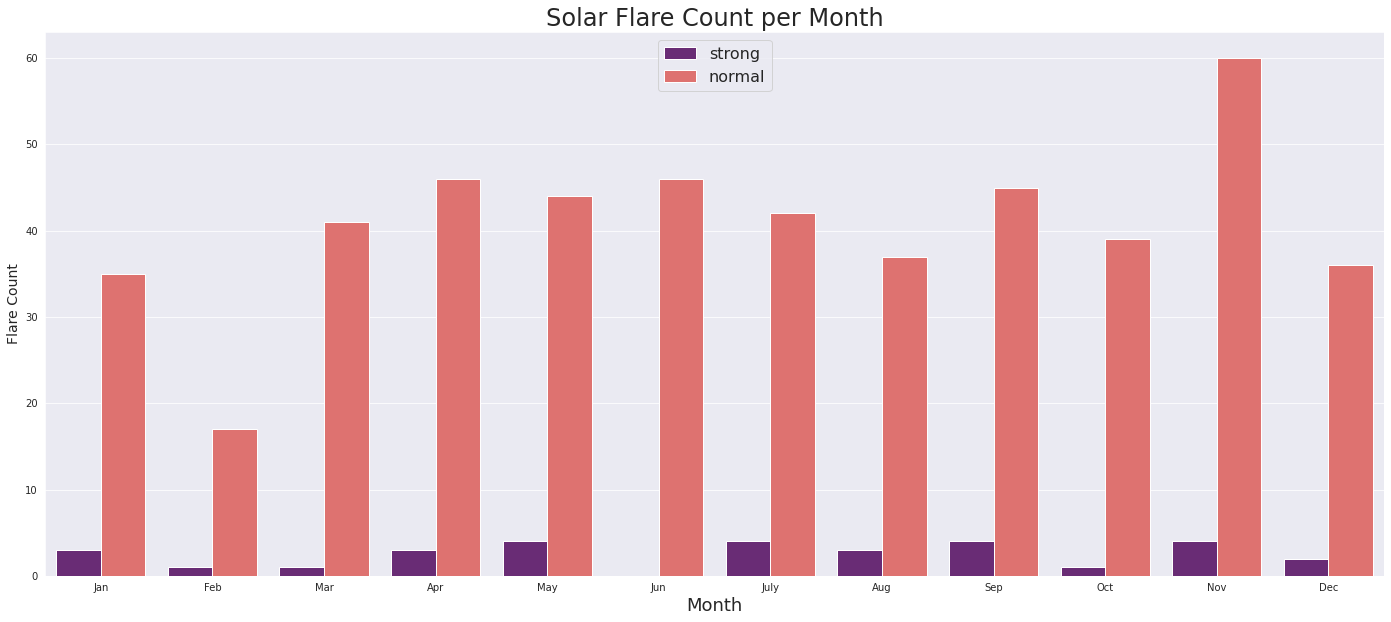

In [20]:
%matplotlib inline

# formatting the plot
plt.figure(figsize=(24,10))
sns.set_style('darkgrid')
bplot = sns.barplot(x='Month', y='Count', hue='Class', palette='magma', data=gb_melted)
bplot.set_xlabel('Month', size=18)
bplot.set_ylabel('Flare Count', size=14)
bplot.set_title('Solar Flare Count per Month', size=24)
plt.legend(fontsize=16, loc=9)

plt.show()

From the plot we can see that both the number of normal flares and the nubmer of strong flares per month are relatively equally distributed. Further analysis could be conducted to determine if any of the month's strong or normal counts have a statistically significant difference from the mean. But for now, at least visually we can confirm solar flares do not cluster around a certain month.